https://www.kaggle.com/code/arinalhaq/garbage-classification-resnet50-96-acc

In [6]:
!pip install torch
!pip install torchvision
!pip install albumentations

  Using cached scikit_image-0.22.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
  Using cached qudida-0.0.4-py3-none-any.whl (3.5 kB)
  Using cached opencv_python-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached lazy_loader-0.3-py3-none-any.whl.metadata (4.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.6/123.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 20.1 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 47.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.4/313.4 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 5.7 MB/s eta 0:00:00ta 0:00:01


In [12]:
!pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.9/800.9 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 34.3 MB/s eta 0:00:00


In [13]:
# notebook78590f1de4

import os
import torch
import torchvision
#import albumentations as A
#from albumentations.pytorch.transforms import ToTensorV2
from torch import nn, utils
from torchvision import transforms
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt

In [14]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomResizedCrop((224, 224)),
        transforms.RandomHorizontalFlip(),
        # transforms.Grayscale(),
        # transforms.Normalize(([0.6731, 0.6398, 0.6048]), ([0.1944, 0.1931, 0.2049]))
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])
}

In [19]:
DATASET_PATH = '../../data'
train_dataset = torchvision.datasets.ImageFolder(DATASET_PATH, transform=data_transforms['train'])
test_dataset = torchvision.datasets.ImageFolder(DATASET_PATH, transform=data_transforms['test'])
print(len(train_dataset))

6208


In [20]:
LABELS = train_dataset.classes
print(train_dataset.class_to_idx)

{'Matières Organiques': 0, 'Mégots': 1, 'Métaux': 2, 'Papier ou Carton': 3, 'Plastique': 4, 'Textile': 5, 'Verre': 6}


In [21]:
torch.manual_seed(1)
np.random.seed(1)
indices = np.random.permutation(len(train_dataset)).tolist()

In [22]:
test_ratio = 0.2
test_border = len(train_dataset) - int(len(train_dataset) * (test_ratio))

train_data = torch.utils.data.Subset(train_dataset, indices[:test_border])
test_data = torch.utils.data.Subset(test_dataset, indices[test_border:])
len(train_data), len(test_data)

(4967, 1241)

In [23]:
train_size = int(0.9 * len(train_data))
val_size = len(train_data) - train_size

train_data, val_data = utils.data.random_split(train_data, [train_size, val_size])
train_size, val_size

(4470, 497)

In [24]:
def show_image(image, label):
    plt.title(f"label: {label}, {LABELS[label]}\n")
    plt.imshow(transforms.ToPILImage()(image).convert('RGB'))

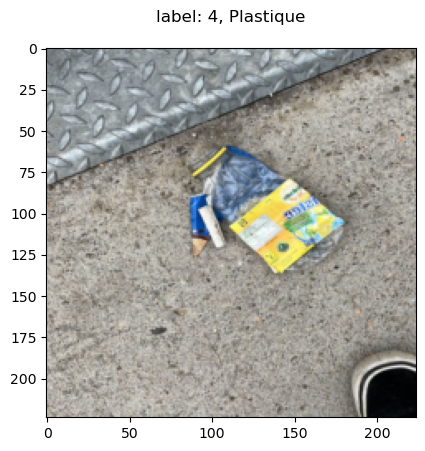

In [25]:
image, label = train_data[0]
show_image(image, label)

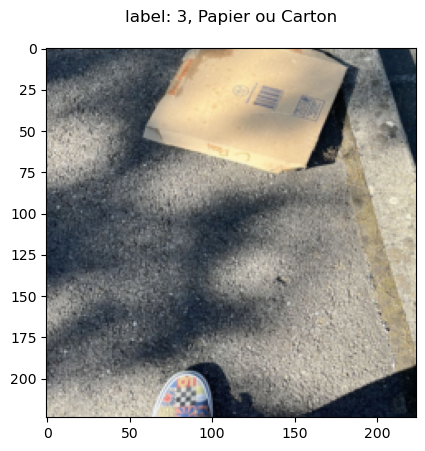

In [26]:
image, label = val_data[0]
show_image(image, label)

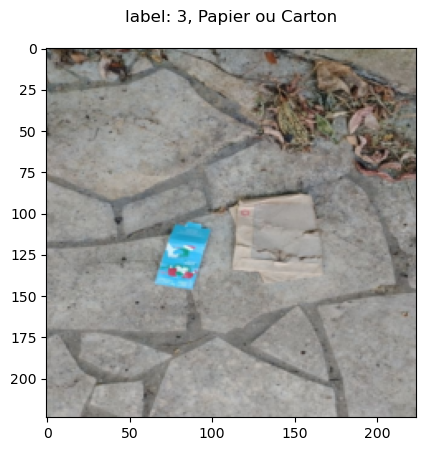

In [27]:
image, label = test_data[0]
show_image(image, label)

In [84]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, num_workers=1)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=4, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=4, num_workers=1)

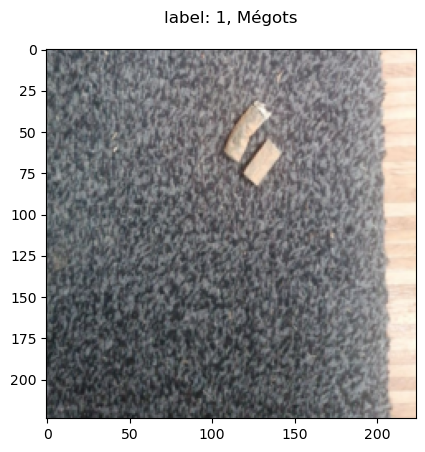

In [29]:
inputs, labels = next(iter(train_loader))
show_image(inputs[0], labels[0])

In [64]:
from pytorch_lightning.callbacks import Callback

class MetricMonitor(Callback):
    def __init__(self):
        self.history = []
        self.epoch = 0

    def on_train_epoch_end(self, trainer, pl_module):
        elogs = {item: float(value) for (item, value) in trainer.logged_metrics.items()}
        print(f"Epoch [{self.epoch}] train_loss: {elogs['train_loss_epoch']:.3f}, val_loss: {elogs['val_loss']:.3f}, train_acc: {elogs['train_acc']:.3f}, val_acc: {elogs['val_acc']:.3f}")
        self.epoch += 1
        self.history.append(elogs)

In [85]:
import torchvision.models as models
import torchmetrics
import torch.nn.functional as F

class LigResNet(pl.LightningModule):
    def __init__(self, lr, num_class, *args, **kwargs):
        super().__init__()
        
        self.save_hyperparameters()
        
        self.model = models.resnet50(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_class)
        
        self.train_acc = torchmetrics.Accuracy(task='multiclass', num_classes=7)
        self.val_acc = torchmetrics.Accuracy(task='multiclass', num_classes=7)
        self.test_acc = torchmetrics.Accuracy(task='multiclass', num_classes=7)
    
    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5)
        return [optimizer], [scheduler]
    
    def training_step(self, batch, batch_idx):
        X, y = batch
        logits = self.model(X)
        loss = F.cross_entropy(logits, y)
        
        self.train_acc(torch.argmax(logits, dim=1), y)
        
        self.log('train_loss', loss.item(), on_epoch=True)
        self.log('train_acc', self.train_acc, on_step=False, on_epoch=True, prog_bar=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        X, y = batch
        logits = self.model(X)
        loss = F.cross_entropy(logits, y)
        
        self.val_acc(torch.argmax(logits, dim=1), y)
        
        self.log('val_loss', loss.item(), on_epoch=True)
        self.log('val_acc', self.val_acc, on_epoch=True)
    
    def test_step(self, batch, batch_idx):
        X, y = batch
        logits = self.model(X)
        loss = F.cross_entropy(logits, y)
        
        self.test_acc(torch.argmax(logits, dim=1), y)
        
        self.log('test_loss', loss.item(), on_epoch=True)
        self.log('test_acc', self.test_acc, on_epoch=True)
    
    def predict_step(self, batch, batch_idx):
        X, y = batch
        preds = self.model(X)
        return preds

In [86]:
class LigResNeXt(pl.LightningModule):
    def __init__(self, lr, num_class, *args, **kwargs):
        super().__init__()
        
        self.save_hyperparameters()
        
        self.model = models.resnext50_32x4d(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_class)
        
        self.train_acc = torchmetrics.Accuracy(task='multiclass', num_classes=7)
        self.val_acc = torchmetrics.Accuracy(task='multiclass', num_classes=7)
        self.test_acc = torchmetrics.Accuracy(task='multiclass',num_classes=7)
    
    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5)
        return [optimizer], [scheduler]
    
    def training_step(self, batch, batch_idx):
        X, y = batch
        logits = self.model(X)
        loss = F.cross_entropy(logits, y)
        
        self.train_acc(torch.argmax(logits, dim=1), y)
        
        self.log('train_loss', loss.item(), on_epoch=True)
        self.log('train_acc', self.train_acc, on_step=False, on_epoch=True, prog_bar=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        X, y = batch
        logits = self.model(X)
        loss = F.cross_entropy(logits, y)
        
        self.val_acc(torch.argmax(logits, dim=1), y)
        
        self.log('val_loss', loss.item(), on_epoch=True)
        self.log('val_acc', self.val_acc, on_epoch=True)
    
    def test_step(self, batch, batch_idx):
        X, y = batch
        logits = self.model(X)
        loss = F.cross_entropy(logits, y)
        
        self.test_acc(torch.argmax(logits, dim=1), y)
        
        self.log('test_loss', loss.item(), on_epoch=True)
        self.log('test_acc', self.test_acc, on_epoch=True)
    
    def predict_step(self, batch, batch_idx):
        X, y = batch
        preds = self.model(X)
        return preds

In [87]:
num_class = len(LABELS)

model_1 = LigResNet(lr=0.00005, num_class=num_class)
model_1.model.fc

Linear(in_features=2048, out_features=7, bias=True)

In [88]:
model_2 = LigResNeXt(lr=0.00005, num_class=num_class)
model_2.model.fc

Linear(in_features=2048, out_features=7, bias=True)

In [89]:
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

mm = MetricMonitor()
csv_log = CSVLogger('logs', name='metric')
es = EarlyStopping('val_loss', patience=3)
mc = ModelCheckpoint(filename='{epoch}-{val_loss}', monitor='val_loss', save_top_k=3)


trainer = pl.Trainer(
    accelerator='gpu',
    limit_train_batches=5,
    max_epochs=20,
    devices=1,
    callbacks=[mm, es, mc],
    default_root_dir='./logs/resnet'
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [90]:
PYTORCH_CUDA_ALLOC_CONF=expandable_segments=True
torch.cuda.empty_cache()

In [80]:
import torch
torch.cuda.memory_summary(device=None, abbreviated=False)


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 10           |        cudaMalloc retries: 10        |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  18816 KiB | 109584 KiB |    904 MiB |    886 MiB |\n|       from large pool |  18816 KiB | 100736 KiB |    738 MiB |    720 MiB |\n|       from small pool |      0 KiB |  17899 KiB |    165 MiB |    165 MiB |\n|---------------------------------------------------------------------------|\n| Active memory         |  18816 KiB | 109584 KiB |    904 MiB |    886 MiB |\n|       from large pool |  18816 KiB | 100736 KiB |

In [91]:
trainer.fit(model_1, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.54 GiB of which 16.56 MiB is free. Process 372090 has 13.06 GiB memory in use. Process 2191617 has 1.27 GiB memory in use. Process 2463824 has 178.00 MiB memory in use. Of the allocated memory 104.26 MiB is allocated by PyTorch, and 13.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [72]:
os.listdir('./logs/resnet/lightning_logs/version_2/checkpoints')

FileNotFoundError: [Errno 2] No such file or directory: './logs/resnet/lightning_logs/version_2/checkpoints'

In [37]:
trainer.test(model_1, test_loader, ckpt_path='best')

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9645504355430603     │
│         test_loss         │    0.11263743042945862    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.11263743042945862, 'test_acc': 0.9645504355430603}]

In [38]:
trainer.test(model_1, test_loader, ckpt_path='./logs/resnet/lightning_logs/version_2/checkpoints/epoch=12-val_loss=0.16482672095298767.ckpt')

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9648727178573608     │
│         test_loss         │     0.116356760263443     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.116356760263443, 'test_acc': 0.9648727178573608}]

In [61]:
mm_2 = MetricMonitor()
es_2 = EarlyStopping('val_loss')
mc_2 = ModelCheckpoint(filename='{epoch}-{val_loss}', monitor='val_loss', save_top_k=3)

trainer_2 = pl.Trainer(
    accelerator='gpu',
    limit_train_batches=100,
    max_epochs=20,
    devices=1,
    callbacks=[mm_2, es_2, mc_2],
    default_root_dir='./logs/resnext'
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [62]:
trainer_2.fit(model_2, train_loader, val_loader)

Missing logger folder: logs/resnext/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ResNet             | 23.0 M
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
23.0 M    Trainable params
0         Non-trainable params
23.0 M    Total params
91.977    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 98.00 MiB. GPU 0 has a total capacity of 14.54 GiB of which 4.56 MiB is free. Process 372090 has 13.06 GiB memory in use. Process 2191617 has 1.27 GiB memory in use. Process 2463824 has 190.00 MiB memory in use. Of the allocated memory 107.02 MiB is allocated by PyTorch, and 22.98 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [43]:
os.listdir('./logs/resnext/lightning_logs/version_0/checkpoints')

['epoch=10-val_loss=0.16532117128372192.ckpt',
 'epoch=11-val_loss=0.17932356894016266.ckpt',
 'epoch=8-val_loss=0.15521308779716492.ckpt']

In [44]:
trainer_2.test(model_2, test_loader, ckpt_path='best')

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.969384491443634     │
│         test_loss         │    0.10856065154075623    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.10856065154075623, 'test_acc': 0.969384491443634}]

In [45]:
trainer_2.test(model_2, test_loader, ckpt_path='./logs/resnext/lightning_logs/version_0/checkpoints/epoch=8-val_loss=0.15521308779716492.ckpt')

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9716403484344482     │
│         test_loss         │    0.10889699310064316    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.10889699310064316, 'test_acc': 0.9716403484344482}]

In [46]:
import yaml

with open("./logs/resnext/lightning_logs/version_0/hparams.yaml", "r") as stream:
    try:
        print(yaml.safe_load(stream))
    except yaml.YAMLError as exc:
        print(exc)

{'lr': 5e-05, 'num_class': 12}
